In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score
from sklearn.metrics import confusion_matrix, auc, roc_curve, ConfusionMatrixDisplay
import optuna


import pickle

print("done")

done


In [86]:
df_train = pd.read_csv("./data/data_processed/train_processed.csv")
df_test = pd.read_csv("./data/data_processed/test_processed.csv")

df_train.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked,Age Class,Title,Is Alone,Total Peers
0,0,3,male,1,0,7.2500,S,young adult,Mr,False,1
1,1,1,female,1,0,71.2833,C,old adult,Mrs,False,1
2,1,3,female,0,0,7.9250,S,young adult,Miss,True,0
3,1,1,female,1,0,53.1000,S,old adult,Mrs,False,1
4,0,3,male,0,0,8.0500,S,old adult,Mr,True,0


### **Split Data For Train and Validation**

In [87]:
X = df_train.drop(columns=['Survived'])
y = df_train['Survived']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((712, 10), (179, 10), (712,), (179,))

### **Data Preprocessing**

In [88]:
def preprocessor_pipeline(num_cols, ohe_cols, ordinal_cols, ordinal_mappings):
    
    numeric_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median"))
    ])

    ohe_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ])

    ordinal_transformers = []
    for i, col in enumerate(ordinal_cols):
        mapping = ordinal_mappings[i]
        ordinal_pipeline = Pipeline([
                ("imputer", SimpleImputer(strategy="most_frequent")),
                ("encoder", OrdinalEncoder(categories=[mapping]))
                ])
        ordinal_transformers.append((col, ordinal_pipeline, [col]))

    transformer = [
        ("numeric_enc", numeric_pipeline, num_cols),
        ("ohe_enc", ohe_pipeline, ohe_cols)
    ] + ordinal_transformers

    preprocessor = ColumnTransformer(transformer)

    return preprocessor

print('done')

done


In [90]:
num_cols = ['Fare', 'SibSp', 'Parch', 'Total Peers']
ohe_cols = ['Sex', 'Embarked', 'Title', 'Is Alone']
ordinal_cols = ['Pclass', 'Age Class']

ordinal_mappings = [np.sort(df_train['Pclass'].unique()).tolist(),
                    ['toddler', 'children', 'teenager', 'young adult', 'middle adult', 'old adult', 'retirement']]

print('done')

done


In [91]:
preprocessor = preprocessor_pipeline(num_cols, ohe_cols, ordinal_cols, ordinal_mappings)
print('done')

done


In [92]:
# Process Train Data

after_transform = preprocessor.fit_transform(X_train, y_train)
new_cat_cols = preprocessor.named_transformers_['ohe_enc'].named_steps['encoder'].get_feature_names_out(ohe_cols)
all_cols = np.concatenate([num_cols,  new_cat_cols, ordinal_cols])

X_train_processed = pd.DataFrame(after_transform, columns=all_cols)
X_train_processed.head()

,Fare,SibSp,Parch,Total Peers,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Other,Is Alone_False,Is Alone_True,Pclass,Age Class
0,56.4958,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,6.0
1,0.0000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,6.0
2,221.7792,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,6.0
3,9.3500,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,2.0
4,26.2500,1.0,1.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,5.0


In [93]:
# Process Validation Data

after_transform = preprocessor.transform(X_val)
new_cat_cols = preprocessor.named_transformers_['ohe_enc'].named_steps['encoder'].get_feature_names_out(ohe_cols)
all_cols = np.concatenate([num_cols,  new_cat_cols, ordinal_cols])

X_val_processed = pd.DataFrame(after_transform, columns=all_cols)
X_val_processed.head()

,Fare,SibSp,Parch,Total Peers,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Other,Is Alone_False,Is Alone_True,Pclass,Age Class
0,24.1500,2.0,0.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,3.0
1,16.1000,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,5.0
2,7.2250,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,3.0
3,14.1083,2.0,0.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,5.0
4,15.5000,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0,6.0


In [96]:
def evaluation(X, y, model, val=True):
    y_pred = model.predict(X)
    
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1  = f1_score(y, y_pred)
    auc = roc_auc_score(y, model.predict_proba(X)[:, 1])

    if val :
        print("Validation Evaluation :")
    else:
        print("Train Evaluation :")

    metric = {"accuracy" : round(accuracy, 2),
            "precision" : round(precision, 2),
            "recall" : round(recall, 2),
            "f1" : round(f1, 2),
            "auc" : round(auc, 2)}
    print(metric)
    return metric

### **Modeling With Default Parameter**

#### 1. Logistic Regression

In [97]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_processed, y_train)

logreg_train = evaluation(X_train_processed, y_train, logreg, val=False)
logreg_val = evaluation(X_val_processed, y_val, logreg)

Train Evaluation :
{'accuracy': 0.83, 'precision': 0.8, 'recall': 0.74, 'f1': 0.77, 'auc': 0.87}
Validation Evaluation :
{'accuracy': 0.85, 'precision': 0.84, 'recall': 0.75, 'f1': 0.79, 'auc': 0.88}


#### 2. KNN

In [98]:
knn = KNeighborsClassifier()
knn.fit(np.array(X_train_processed), y_train)

knn_train = evaluation(X_train_processed.values, y_train, knn, val=False)
knn_val = evaluation(X_val_processed.values, y_val, knn)

Train Evaluation :
{'accuracy': 0.84, 'precision': 0.8, 'recall': 0.78, 'f1': 0.79, 'auc': 0.92}
Validation Evaluation :
{'accuracy': 0.73, 'precision': 0.66, 'recall': 0.64, 'f1': 0.65, 'auc': 0.75}


### 3. Naive Bayes

In [99]:
nb = GaussianNB()
nb.fit(X_train_processed, y_train)

nb_train = evaluation(X_train_processed, y_train, nb, val=False)
nb_val = evaluation(X_val_processed, y_val, nb)

Train Evaluation :
{'accuracy': 0.8, 'precision': 0.72, 'recall': 0.77, 'f1': 0.74, 'auc': 0.85}
Validation Evaluation :
{'accuracy': 0.8, 'precision': 0.74, 'recall': 0.77, 'f1': 0.75, 'auc': 0.84}


### 4. SVC

In [100]:
svc = SVC(probability=True)
svc.fit(X_train_processed, y_train)

svc_train = evaluation(X_train_processed, y_train, svc, val=False)
svc_val = evaluation(X_val_processed, y_val, svc)

Train Evaluation :
{'accuracy': 0.7, 'precision': 0.72, 'recall': 0.34, 'f1': 0.46, 'auc': 0.79}
Validation Evaluation :
{'accuracy': 0.64, 'precision': 0.58, 'recall': 0.26, 'f1': 0.36, 'auc': 0.73}


### 5. Decicion Tree

In [101]:
dt = DecisionTreeClassifier()
dt.fit(X_train_processed, y_train)

dt_train = evaluation(X_train_processed, y_train, dt, val=False)
dt_val = evaluation(X_val_processed, y_val, dt)

Train Evaluation :
{'accuracy': 0.96, 'precision': 0.98, 'recall': 0.92, 'f1': 0.95, 'auc': 1.0}
Validation Evaluation :
{'accuracy': 0.8, 'precision': 0.76, 'recall': 0.7, 'f1': 0.73, 'auc': 0.75}


### 6. Random Forest

In [102]:
rf = RandomForestClassifier()
rf.fit(X_train_processed, y_train)

rf_train = evaluation(X_train_processed, y_train, rf, val=False)
rf_val = evaluation(X_val_processed, y_val, rf)

Train Evaluation :
{'accuracy': 0.96, 'precision': 0.96, 'recall': 0.93, 'f1': 0.95, 'auc': 0.99}
Validation Evaluation :
{'accuracy': 0.82, 'precision': 0.78, 'recall': 0.74, 'f1': 0.76, 'auc': 0.81}


### 7. Gradient Boosting

In [103]:
gb = GradientBoostingClassifier()
gb.fit(X_train_processed, y_train)

gb_train = evaluation(X_train_processed, y_train, gb, val=False)
gb_val = evaluation(X_val_processed, y_val, gb)

Train Evaluation :
{'accuracy': 0.91, 'precision': 0.92, 'recall': 0.84, 'f1': 0.88, 'auc': 0.96}
Validation Evaluation :
{'accuracy': 0.83, 'precision': 0.8, 'recall': 0.74, 'f1': 0.77, 'auc': 0.85}


### 7. Extreme Gradient Boosting

In [104]:
xgb = XGBClassifier()
xgb.fit(X_train_processed, y_train)

xgb_train = evaluation(X_train_processed, y_train, xgb, val=False)
xgb_val = evaluation(X_val_processed, y_val, xgb)

Train Evaluation :
{'accuracy': 0.95, 'precision': 0.97, 'recall': 0.91, 'f1': 0.94, 'auc': 0.99}
Validation Evaluation :
{'accuracy': 0.79, 'precision': 0.75, 'recall': 0.68, 'f1': 0.71, 'auc': 0.81}


### **Model Selection**

In [105]:
pd.DataFrame({"model": ["logistic regression", "knn", "naive bayes", "svc", "decision tree", "random forest", "gradient boosting", "xgboost"],

              "accuracy train" : [logreg_train['accuracy'], knn_train['accuracy'], nb_train['accuracy'], svc_train['accuracy'], 
                                  dt_train['accuracy'], rf_train['accuracy'], gb_train['accuracy'], xgb_train['accuracy']],
              "accuracy val" : [logreg_val['accuracy'], knn_val['accuracy'], nb_val['accuracy'], svc_val['accuracy'], 
                                dt_val['accuracy'], rf_val['accuracy'], gb_val['accuracy'], xgb_val['accuracy']],
              
              "precision train":[logreg_train['precision'], knn_train['precision'], nb_train['precision'], svc_train['precision'], 
                                 dt_train['precision'], rf_train['precision'], gb_train['precision'], xgb_train['precision']],
              "precision val" : [logreg_val['precision'], knn_val['precision'], nb_val['precision'], svc_val['precision'], 
                                 dt_val['precision'], rf_val['precision'],gb_val['precision'], xgb_val['precision']],
             
              "recall train":[logreg_train['recall'], knn_train['recall'], nb_train['recall'], svc_train['recall'], 
                                 dt_train['recall'], rf_train['recall'], gb_train['recall'], xgb_train['recall']],
              "recall val" : [logreg_val['recall'], knn_val['recall'], nb_val['recall'], svc_val['recall'], 
                                 dt_val['recall'], rf_val['recall'],gb_val['recall'], xgb_val['recall']],
             
              "f1 train":[logreg_train['f1'], knn_train['f1'], nb_train['f1'], svc_train['f1'], 
                                 dt_train['f1'], rf_train['f1'], gb_train['f1'], xgb_train['f1']],
              "f1 val" : [logreg_val['f1'], knn_val['f1'], nb_val['f1'], svc_val['f1'], 
                                 dt_val['f1'], rf_val['f1'],gb_val['f1'], xgb_val['f1']],
             
             "auc train":[logreg_train['auc'], knn_train['auc'], nb_train['auc'], svc_train['auc'], 
                                 dt_train['auc'], rf_train['auc'], gb_train['auc'], xgb_train['auc']],
              "auc val" : [logreg_val['auc'], knn_val['auc'], nb_val['auc'], svc_val['auc'], 
                                 dt_val['auc'], rf_val['auc'],gb_val['auc'], xgb_val['auc']],})

,model,accuracy train,accuracy val,precision train,precision val,recall train,recall val,f1 train,f1 val,auc train,auc val
0,logistic regression,0.83,0.85,0.80,0.84,0.74,0.75,0.77,0.79,0.87,0.88
1,knn,0.84,0.73,0.80,0.66,0.78,0.64,0.79,0.65,0.92,0.75
2,naive bayes,0.80,0.80,0.72,0.74,0.77,0.77,0.74,0.75,0.85,0.84
3,svc,0.70,0.64,0.72,0.58,0.34,0.26,0.46,0.36,0.79,0.73
4,decision tree,0.96,0.80,0.98,0.76,0.92,0.70,0.95,0.73,1.00,0.75
5,random forest,0.96,0.82,0.96,0.78,0.93,0.74,0.95,0.76,0.99,0.81
6,gradient boosting,0.91,0.83,0.92,0.80,0.84,0.74,0.88,0.77,0.96,0.85
7,xgboost,0.95,0.79,0.97,0.75,0.91,0.68,0.94,0.71,0.99,0.81


### **1. Hyperparameter Tune and CV: Logistic Regression**

In [130]:
def create_cm_plot(X, y, model, val=True):
    y_pred = model.predict(X)
    cm = confusion_matrix(y, y_pred)

    fig = plt.figure(figsize=(4, 3))
    sns.set(font_scale=0.8)

    ax = sns.heatmap(cm, annot=True, fmt='g')
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.xaxis.set_ticklabels(['Not Survived', 'Survived'])
    ax.yaxis.set_ticklabels(['Not survived', 'Survived'])

    if val :
        ax.set_title("Confusion Matrix Validation")
    else:
        ax.set_title("Confusion Matrix Train")
    plt.show()

In [135]:
def objective(trial):
    params = {
        "C": trial.suggest_loguniform("C", 0.001, 10),
        "max_iter": trial.suggest_int("max_iter", 50, 500),
        "solver": trial.suggest_categorical("solver", ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]),
    }
    
    # fit the model
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('lr', LogisticRegression(**params))
        ])
    
    # cross validation
    cv = StratifiedKFold(n_splits=3, shuffle=True)
    score = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring="f1")
    score = score.mean()
    return score

# tuning
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

trial = study.best_trial
print("Best Score: {}".format(trial.value))
print("Best Params: ")
for key, value in trial.params.items(): 
    print("     {}: {}".format(key, value))

[I 2023-08-21 05:23:59,722] A new study created in memory with name: no-name-0930078d-4439-4a67-bd81-5ca1cec2ea30
C:\Users\YULIKA-DS\AppData\Local\Temp\ipykernel_15096\1116951752.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "C": trial.suggest_loguniform("C", 0.001, 10),
[I 2023-08-21 05:23:59,822] Trial 0 finished with value: 0.5691297208538587 and parameters: {'C': 0.00820503407775978, 'max_iter': 280, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.5691297208538587.
C:\Users\YULIKA-DS\AppData\Local\Temp\ipykernel_15096\1116951752.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "C": trial.suggest_loguniform("C", 0.001, 10),
[I 2023-08-21 05:23:59,889] Tria

Best Score: 0.7641255737057038
Best Params: 
     C: 0.9657228491045836
     max_iter: 183
     solver: liblinear


In [136]:
best_params = trial.params`
best_params

{'C': 0.9657228491045836, 'max_iter': 183, 'solver': 'liblinear'}

In [137]:
def model_training(X_train, y_train, params, preprocessor):
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('lr', LogisticRegression(**params))
        ])

    model = pipeline.fit(X_train, y_train)
    return model

# best_params = trial.params
model_tune = model_training(X_train, y_train, params=best_params, preprocessor=preprocessor)

### Evaluation Model : Logistic Regression

In [138]:
#Evaluation
metric_train = evaluation(X_train, y_train, model_tune, val=False)
metric_val = evaluation(X_val, y_val, model_tune)

Train Evaluation :
{'accuracy': 0.83, 'precision': 0.8, 'recall': 0.74, 'f1': 0.77, 'auc': 0.87}
Validation Evaluation :
{'accuracy': 0.85, 'precision': 0.84, 'recall': 0.75, 'f1': 0.79, 'auc': 0.88}


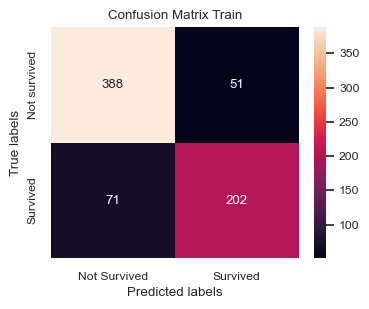

In [140]:
# confusion matrix
cm_plot_train_pl = create_cm_plot(X_train, y_train, model_tune, val=False)

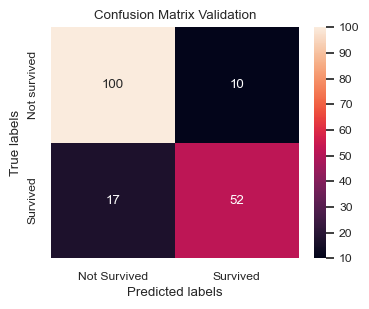

In [141]:
cm_plot_val_pl = create_cm_plot(X_val, y_val, model_tune)

### Export Model : Logistic Regression

In [142]:
pickle.dump(model_tune, open('model_logistic_regression.pkl', 'wb'))
print('done')

done


### **2. Hyperparameter Tune and CV: Gradient Boosting**

In [118]:
def objective(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log="True"),
        "n_estimators": trial.suggest_int("n_estimators", 50, 100),
        "max_depth": trial.suggest_int("max_depth", 3, 5),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.11, 0.5),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"])
    }
    
    # fit the model
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('xgb', GradientBoostingClassifier(**params))
        ])
    
    # cross validation
    cv = StratifiedKFold(n_splits=3, shuffle=True)
    score = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring="f1")
    score = score.mean()
    return score

# tuning
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

trial = study.best_trial
print("Best Score: {}".format(trial.value))
print("Best Params: ")
for key, value in trial.params.items(): 
    print("     {}: {}".format(key, value))

[I 2023-08-21 04:44:38,195] A new study created in memory with name: no-name-81b2a3d2-c97b-4fe7-ad79-2979e67e34bb
[I 2023-08-21 04:44:38,356] Trial 0 finished with value: 0.756093661852547 and parameters: {'learning_rate': 0.0667245237093531, 'n_estimators': 63, 'max_depth': 4, 'min_samples_leaf': 3, 'subsample': 0.2129668577819286, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.756093661852547.
[I 2023-08-21 04:44:38,524] Trial 1 finished with value: 0.7325713615675747 and parameters: {'learning_rate': 0.029287922125728543, 'n_estimators': 80, 'max_depth': 5, 'min_samples_leaf': 7, 'subsample': 0.1260461156452481, 'max_features': 'log2'}. Best is trial 0 with value: 0.756093661852547.
[I 2023-08-21 04:44:38,670] Trial 2 finished with value: 0.7589688453932935 and parameters: {'learning_rate': 0.06772177130382284, 'n_estimators': 54, 'max_depth': 3, 'min_samples_leaf': 7, 'subsample': 0.2009780919761786, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.7589688453932935.
[

Best Score: 0.7605508428629816
Best Params: 
     learning_rate: 0.05051978422192952
     n_estimators: 62
     max_depth: 3
     min_samples_leaf: 2
     subsample: 0.2721883955179462
     max_features: log2


In [119]:
best_params = trial.params
best_params

{'learning_rate': 0.05051978422192952,
 'n_estimators': 62,
 'max_depth': 3,
 'min_samples_leaf': 2,
 'subsample': 0.2721883955179462,
 'max_features': 'log2'}

In [127]:
def model_training(X_train, y_train, params, preprocessor):
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('xgb', GradientBoostingClassifier(**params))
        ])

    model = pipeline.fit(X_train, y_train)
    return model

# best_params = trial.params
model_tune = model_training(X_train, y_train, params=best_params, preprocessor=preprocessor)

### Evaluation Model : Gradient Boosting 

In [132]:
#Evaluation
metric_train = evaluation(X_train, y_train, model_tune, val=False)
metric_val = evaluation(X_val, y_val, model_tune)

Train Evaluation :
{'accuracy': 0.84, 'precision': 0.83, 'recall': 0.73, 'f1': 0.78, 'auc': 0.89}
Validation Evaluation :
{'accuracy': 0.83, 'precision': 0.8, 'recall': 0.74, 'f1': 0.77, 'auc': 0.86}


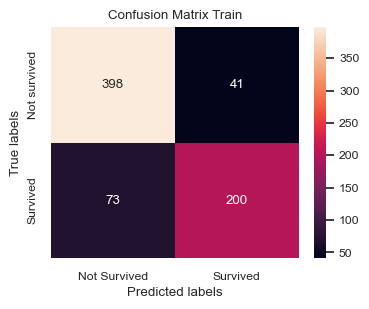

In [133]:
# confusion matrix
cm_plot_train_pl = create_cm_plot(X_train, y_train, model_tune, val=False)

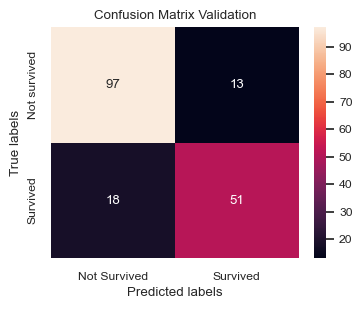

In [134]:
cm_plot_val_pl = create_cm_plot(X_val, y_val, model_tune)

### Export Model : Gradient Boosting

In [121]:
pickle.dump(model_tune, open('model_gradient_boost.pkl', 'wb'))
print('done')

done
